In [1]:
import os
import pandas as pd
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from eunjeon import Mecab
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, f1_score

from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Bidirectional
from gensim.models import Word2Vec

plt.rc('font', family='Malgun Gothic')


In [2]:
# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [3]:
data_dir = '../analysis_files/files/'
data_dir2 = '../analysis_files/word2vec/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# mecab 모델 다운로드
tokenizer = Mecab()

In [4]:
def load_dataset(data_dir):
    df = pd.read_csv(os.path.join(data_dir, '감성대화말뭉치(최종데이터)_Validation.csv'), encoding='cp949')
    df = df[['사람문장1', '감정_대분류', '상황키워드']]

    # NaN values and empty strings removal
    df.dropna(subset=['사람문장1'], inplace=True)
    df = df[df.astype(str).ne('').all(axis=1)]

    # Label encoding
    emotion_encoder = LabelEncoder()
    df['emotion'] = emotion_encoder.fit_transform(df['감정_대분류'])
    situation_encoder = LabelEncoder()
    df['situation'] = situation_encoder.fit_transform(df['상황키워드'])

    # Create label mapping dictionaries
    emotion_mapping = dict(zip(emotion_encoder.classes_, emotion_encoder.transform(emotion_encoder.classes_)))
    situation_mapping = dict(zip(situation_encoder.classes_, situation_encoder.transform(situation_encoder.classes_)))

    # Data split
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=seed)
    
    return train_df, test_df, emotion_mapping, situation_mapping

In [5]:
train_df, test_df, emotion_mapping, situation_mapping = load_dataset(data_dir)

# Print the label mappings
print("Emotion Label Mapping:")
for emotion, encoded_label in emotion_mapping.items():
    print(f"{emotion}: {encoded_label}")

print("\nSituation Label Mapping:")
for situation, encoded_label in situation_mapping.items():
    print(f"{situation}: {encoded_label}")

Emotion Label Mapping:
기쁨: 0
당황: 1
분노: 2
불안: 3
상처: 4
슬픔: 5

Situation Label Mapping:
가족관계: 0
건강: 1
건강,죽음: 2
대인관계: 3
대인관계(부부, 자녀): 4
연애,결혼,출산: 5
재정: 6
재정,은퇴,노후준비: 7
직장, 업무 스트레스: 8
진로,취업,직장: 9
학교폭력/따돌림: 10
학업 및 진로: 11


In [6]:
train_df.head()

,사람문장1,감정_대분류,상황키워드,emotion,situation
1272,부장님은 왜 업무적인 부분을 지적하는 게 아니라 인신공격을 해서 기분 나쁘게 하시는...,분노,"진로,취업,직장",2,9
6215,회사에서는 아무래도 조심스러워지는 것 같아.,불안,"진로,취업,직장",3,9
4490,자꾸 이상한 고객이 전화 와서 날 짜증 나게 해.,분노,"직장, 업무 스트레스",2,8
6055,결혼하고 아이 낳고 행복할 줄 알았는데 희생된 기분이야.,상처,"연애,결혼,출산",4,5
2868,아내가 먼지에 민감한데 딸이 강아지를 돌봐달라며 맡겼어. 상의도 없이 맡겨서 화가 나.,분노,"건강,죽음",2,2


In [7]:
utterance_train = train_df['사람문장1'].tolist()
label_emotion_train = train_df['emotion'].tolist()
label_situation_train = train_df['situation'].tolist()
utterance_test = test_df['사람문장1'].tolist()
label_emotion_test = test_df['emotion'].tolist()
label_situation_test = test_df['situation'].tolist()

print('훈련용 문장의 수 :', len(utterance_train))
print('훈련용 감정레이블의 수 :', len(label_emotion_train))
print('훈련용 원인레이블의 수 :', len(label_situation_train))
print('테스트용 문장의 수 :', len(utterance_test))
print('테스트용 감정레이블의 수 :', len(label_emotion_test))
print('테스트용 원인레이블의 수 :', len(label_situation_test))

훈련용 문장의 수 : 5312
훈련용 감정레이블의 수 : 5312
훈련용 원인레이블의 수 : 5312
테스트용 문장의 수 : 1329
테스트용 감정레이블의 수 : 1329
테스트용 원인레이블의 수 : 1329


<Axes: xlabel='감정_대분류'>

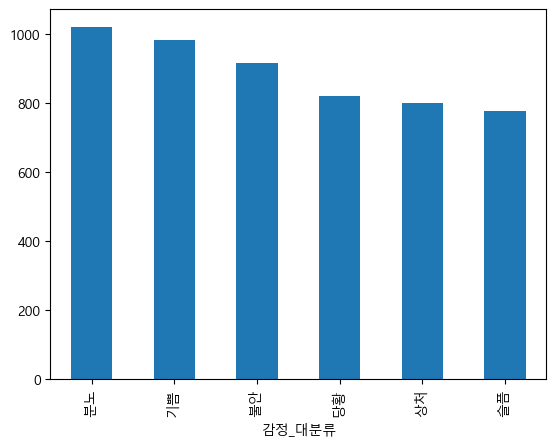

In [8]:
train_df['감정_대분류'].value_counts().plot(kind = 'bar')

<Axes: xlabel='감정_대분류'>

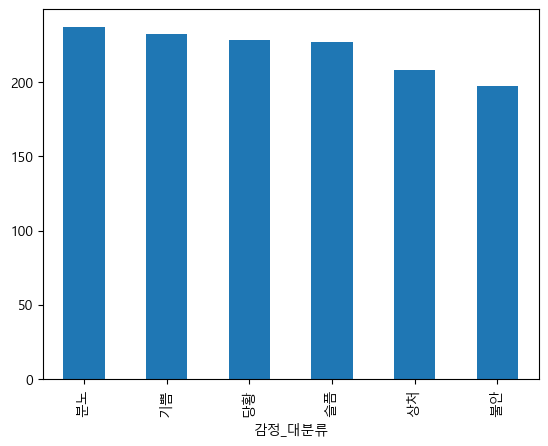

In [9]:
test_df['감정_대분류'].value_counts().plot(kind = 'bar')

<Axes: xlabel='상황키워드'>

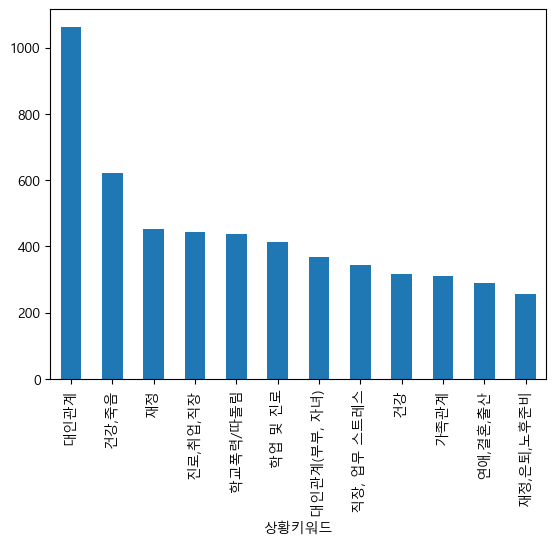

In [10]:
train_df['상황키워드'].value_counts().plot(kind = 'bar')

<Axes: xlabel='상황키워드'>

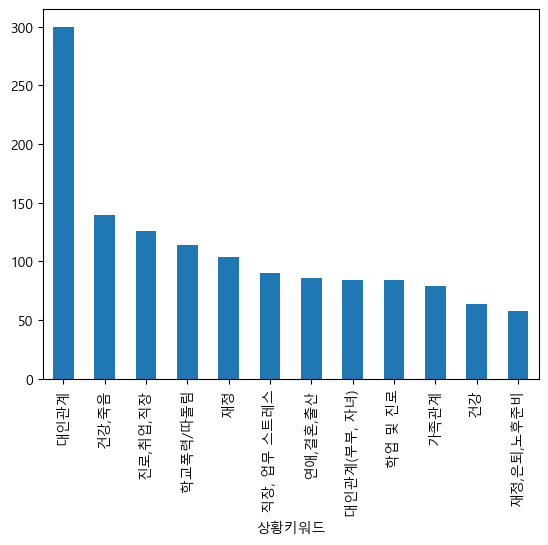

In [11]:
test_df['상황키워드'].value_counts().plot(kind = 'bar')

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['사람문장1'].tolist())
sequences_train = tokenizer.texts_to_sequences(train_df['사람문장1'].tolist())
sequences_test = tokenizer.texts_to_sequences(test_df['사람문장1'].tolist())
sequences_train[:5] # 상위 5개 샘플 출력

[[1657, 67, 2824, 2096, 4673, 9, 732, 4674, 15, 377, 2825, 2826, 1189],
 [1658, 671, 4675, 6, 7],
 [44, 672, 4676, 2097, 180, 47, 75, 1385, 32],
 [673, 2827, 2098, 2828, 98, 219, 1659, 163],
 [31, 4677, 4678, 66, 2099, 4679, 2829, 2830, 108, 4680, 10, 4]]

In [13]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print('단어 집합(Vocabulary)의 크기 :',vocab_size)

단어 집합(Vocabulary)의 크기 : 13428


문장의 최대 길이 : 27
문장의 평균 길이 : 9.665474397590362


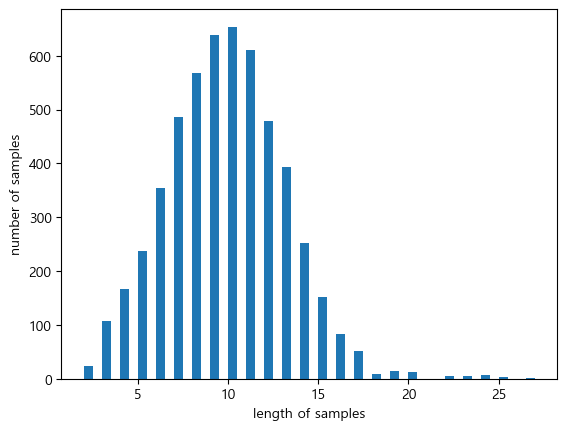

In [14]:
print('문장의 최대 길이 :',max(len(l) for l in sequences_train))
print('문장의 평균 길이 :',sum(map(len, sequences_train))/len(sequences_train))
plt.hist([len(s) for s in sequences_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [15]:
max_len = 30

utterance_train = pad_sequences(sequences_train, maxlen=max_len)
utterance_test = pad_sequences(sequences_test, maxlen=max_len)

label_emotion_train = to_categorical(train_df['emotion'])
label_situation_train = to_categorical(train_df['situation'])
label_emotion_test = to_categorical(test_df['emotion'])
label_situation_test = to_categorical(test_df['situation'])

print('훈련 데이터의 크기(shape):', utterance_train.shape)
print('훈련 데이터 감정레이블의 크기(shape):', label_emotion_train.shape)
print('훈련 데이터 원인레이블의 크기(shape):', label_situation_train.shape)

훈련 데이터의 크기(shape): (5312, 30)
훈련 데이터 감정레이블의 크기(shape): (5312, 6)
훈련 데이터 원인레이블의 크기(shape): (5312, 12)


In [16]:
print('훈련 데이터의 첫번째 샘플 :',utterance_train[0])
print('훈련 데이터의 첫번째 샘플의 감정레이블 :',label_emotion_train[0])
print('훈련 데이터의 첫번째 샘플의 원인레이블 :',label_situation_train[0])

훈련 데이터의 첫번째 샘플 : [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0 1657   67 2824 2096 4673    9  732 4674   15  377 2825
 2826 1189]
훈련 데이터의 첫번째 샘플의 감정레이블 : [0. 0. 1. 0. 0. 0.]
훈련 데이터의 첫번째 샘플의 원인레이블 : [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [17]:
indices_train = np.arange(utterance_train.shape[0])
np.random.shuffle(indices_train)
print('랜덤 시퀀스 :',indices_train)

indices_test = np.arange(utterance_test.shape[0])
np.random.shuffle(indices_test)

랜덤 시퀀스 : [3975 2531 2297 ... 3686 1663 2364]


In [18]:
X_train = utterance_train[indices_train]
y_emotion_train = label_emotion_train[indices_train]
y_situation_train = label_situation_train[indices_train]

X_test = utterance_test[indices_test]
y_emotion_test = label_emotion_test[indices_test]
y_situation_test = label_situation_test[indices_test]

In [19]:
embedding_dict = dict()
# 사전 훈련된 Word2Vec 모델을 로드
model = Word2Vec.load(os.path.join(data_dir2, 'ko.bin'))

In [20]:
for word in model.wv.vocab:
    embedding_dict[word] = model.wv[word]
    
print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))

30185개의 Embedding vector가 있습니다.


In [21]:
print(embedding_dict['우울'])
print(len(embedding_dict['우울']))

[-1.21498978e+00 -5.43866694e-01  1.32688725e+00 -6.49432898e-01
 -4.38877225e-01  5.52123845e-01  4.83556360e-01  1.02437699e+00
 -2.07902670e-01  1.21977139e+00 -5.29723316e-02  2.83519924e-01
  3.75814110e-01  6.29925787e-01 -5.16617894e-01 -2.62273163e-01
 -1.77138105e-01  7.17207134e-01  1.64666355e-01 -1.71311915e-01
  5.11819899e-01  4.22978140e-02  2.26164639e-01  7.59881958e-02
  3.07586491e-01  6.97090849e-02 -4.44131732e-01  9.51295376e-01
 -9.61420715e-01 -3.31237733e-01  3.33495051e-01 -2.93511562e-02
  4.39231545e-01  2.65127450e-01 -3.65351290e-01 -7.63717890e-01
  7.36222565e-02 -9.49564651e-02  2.45211333e-01  6.11337125e-01
 -1.75878897e-01  6.61108434e-01  1.19337216e-02 -8.98760736e-01
  9.82642323e-02  5.10104120e-01 -3.21627408e-01  2.17479408e-01
  3.48298520e-01  1.51318341e-01 -2.26444125e-01  3.23872238e-01
 -6.18719637e-01  9.16367769e-01 -7.72069275e-01 -2.47000799e-01
 -4.40212220e-01  1.47606462e-01  2.45241672e-01  6.81707561e-01
 -1.40714899e-01  3.91073

In [22]:
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
print('임베딩 테이블의 크기(shape) :',np.shape(embedding_matrix))


임베딩 테이블의 크기(shape) : (13428, 200)


In [23]:
for word, i in word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [27]:
num_units = 128
dropout_ratio = 0.5

model_input = Input(shape=(max_len,))
output = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                   input_length=max_len, trainable=False)(model_input)

# Bi-LSTM layer instead of Conv1D
output = Bidirectional(LSTM(num_units, return_sequences=True))(output)

# GlobalMaxPooling1D is not applicable for RNN, we can use GlobalMaxPooling1D after Bi-LSTM with TimeDistributed
output = GlobalMaxPooling1D()(output)

output = Dropout(dropout_ratio)(output)



In [28]:
# Emotion classification model
num_emotion_classes = len(emotion_mapping)
model_output_emotion = Dense(num_emotion_classes, activation='softmax')(output)
model_emotion = Model(model_input, model_output_emotion)

model_emotion.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model_emotion.summary()

history_emotion = model_emotion.fit(X_train, y_emotion_train,
                                    batch_size=32,
                                    epochs=100,
                                    validation_data=(X_test, y_emotion_test))


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 30, 200)           2685600   
                                                                 
 bidirectional_1 (Bidirecti  (None, 30, 256)           336896    
 onal)                                                           
                                                                 
 global_max_pooling1d_1 (Gl  (None, 256)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 6)                 1542

Epoch 1/100
166/166 [==============================] - 6s 27ms/step - loss: 1.7245 - acc: 0.2600 - val_loss: 1.6738 - val_acc: 0.3070
Epoch 2/100
166/166 [==============================] - 4s 22ms/step - loss: 1.6250 - acc: 0.3353 - val_loss: 1.6533 - val_acc: 0.2987
Epoch 3/100
166/166 [==============================] - 4s 22ms/step - loss: 1.5688 - acc: 0.3692 - val_loss: 1.6516 - val_acc: 0.3078
Epoch 4/100
166/166 [==============================] - 4s 21ms/step - loss: 1.5191 - acc: 0.3895 - val_loss: 1.6528 - val_acc: 0.3062
Epoch 5/100
166/166 [==============================] - 3s 21ms/step - loss: 1.4719 - acc: 0.4113 - val_loss: 1.6543 - val_acc: 0.3078
Epoch 6/100
166/166 [==============================] - 3s 21ms/step - loss: 1.4342 - acc: 0.4300 - val_loss: 1.6760 - val_acc: 0.3070
Epoch 7/100
166/166 [==============================] - 3s 20ms/step - loss: 1.3830 - acc: 0.4652 - val_loss: 1.7008 - val_acc: 0.3228
Epoch 8/100
166/166 [==============================] - 3s 20ms

In [29]:
# Situation classification model
num_situation_classes = len(situation_mapping)
model_output_situation = Dense(num_situation_classes, activation='softmax')(output)
model_situation = Model(model_input, model_output_situation)

model_situation.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model_situation.summary()

history_situation = model_situation.fit(X_train, y_situation_train,
                                        batch_size=32,
                                        epochs=100,
                                        validation_data=(X_test, y_situation_test))

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 30, 200)           2685600   
                                                                 
 bidirectional_1 (Bidirecti  (None, 30, 256)           336896    
 onal)                                                           
                                                                 
 global_max_pooling1d_1 (Gl  (None, 256)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 12)                3084

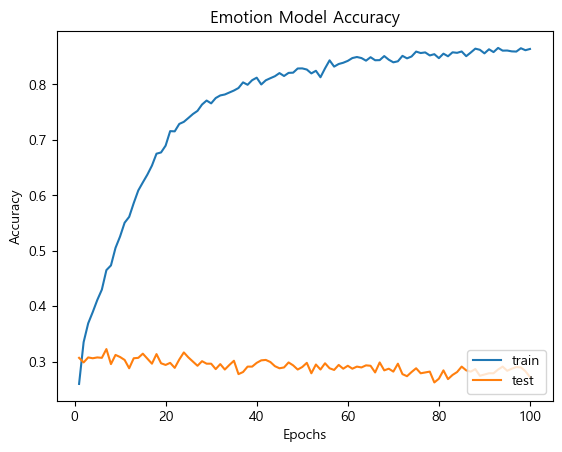

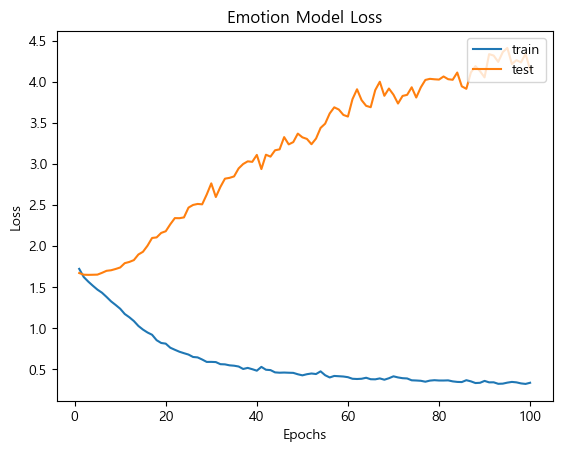

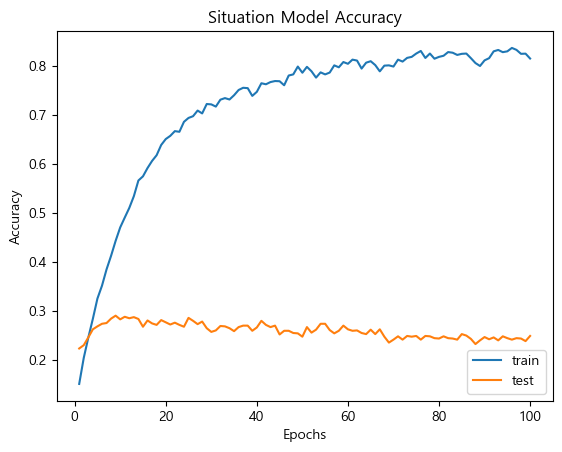

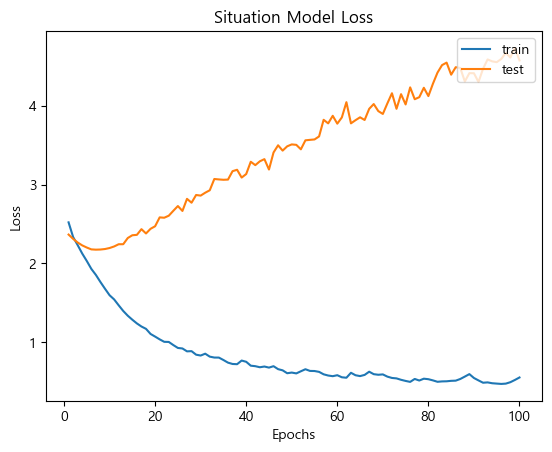

In [30]:
# Plot accuracy and loss graphs for emotion classification
epochs = range(1, len(history_emotion.history['acc']) + 1)
plt.plot(epochs, history_emotion.history['acc'])
plt.plot(epochs, history_emotion.history['val_acc'])
plt.title('Emotion Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

epochs = range(1, len(history_emotion.history['loss']) + 1)
plt.plot(epochs, history_emotion.history['loss'])
plt.plot(epochs, history_emotion.history['val_loss'])
plt.title('Emotion Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Plot accuracy and loss graphs for situation classification
epochs = range(1, len(history_situation.history['acc']) + 1)
plt.plot(epochs, history_situation.history['acc'])
plt.plot(epochs, history_situation.history['val_acc'])
plt.title('Situation Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

epochs = range(1, len(history_situation.history['loss']) + 1)
plt.plot(epochs, history_situation.history['loss'])
plt.plot(epochs, history_situation.history['val_loss'])
plt.title('Situation Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()